In [1]:
import os
import json
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import Dataset, DataLoader

In [2]:
def interleaved_to_complex(source_data):
    """
    Convert interleaved IQ data to complex numbers
    """
    source_data = np.array(source_data)
    source_data = source_data / 32768
    source_data = source_data.astype(np.float32).view(np.complex64)
    return source_data


def iq_to_psd(iq_data, num_fft, sample_rate):
    """
    # Compute the PSD of the input IQ data
    """
    freq, psd = signal.welch(
        iq_data, fs=sample_rate, nperseg=num_fft, return_onesided=False
    )
    return psd


def read_labels(file_path):
    """
    Reads a CSV file with two columns (x, y) and returns a dictionary with x as the key and y as the value
    """
    labels = {}
    with open(file_path, "r") as f:
        for line in f:
            label = line.strip().split(",")
            label[0] = int(label[0])
            labels[label[0]] = {"wifi": 0, "bluetooth": 1}.get(label[1], -1)
    return labels


def read_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

class psd_dataset(Dataset):
    def __init__(self, data_directory, labels):
        self.labels = read_labels(labels)
        self.data_directory = data_directory

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data_path = os.path.join(self.data_directory, f"data_{idx}.npy")
        data = torch.from_numpy(np.load(data_path))
        label = self.labels[idx]
        return data, label

In [3]:
training_dataset = psd_dataset(
    "./data/training_data_psd", "./data/training_data_psd/labels.csv"
)
testing_dataset = psd_dataset(
    "./data/testing_data_psd", "./data/testing_data_psd/labels.csv"
)
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=16)
testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=True, num_workers=16)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


Epoch 1:	Accuracy: 50.67%	Test Loss: 1.150958	Train Loss: 0.159124
Epoch 2:	Accuracy: 50.67%	Test Loss: 1.417694	Train Loss: 0.070680
Epoch 3:	Accuracy: 50.67%	Test Loss: 1.514150	Train Loss: 0.029043
Epoch 4:	Accuracy: 50.67%	Test Loss: 1.311808	Train Loss: 0.022870
Epoch 5:	Accuracy: 50.67%	Test Loss: 0.766630	Train Loss: 0.017079
Epoch 6:	Accuracy: 96.00%	Test Loss: 0.195122	Train Loss: 0.019652
Epoch 7:	Accuracy: 100.00%	Test Loss: 0.055836	Train Loss: 0.012715
Epoch 8:	Accuracy: 100.00%	Test Loss: 0.023039	Train Loss: 0.013838
Epoch 9:	Accuracy: 100.00%	Test Loss: 0.014954	Train Loss: 0.007565
Epoch 10:	Accuracy: 100.00%	Test Loss: 0.008568	Train Loss: 0.006484
Epoch 11:	Accuracy: 100.00%	Test Loss: 0.006828	Train Loss: 0.012493
Epoch 12:	Accuracy: 100.00%	Test Loss: 0.005481	Train Loss: 0.005415
Epoch 13:	Accuracy: 100.00%	Test Loss: 0.004487	Train Loss: 0.003964
Epoch 14:	Accuracy: 100.00%	Test Loss: 0.003948	Train Loss: 0.004404
Epoch 15:	Accuracy: 100.00%	Test Loss: 0.003350	T

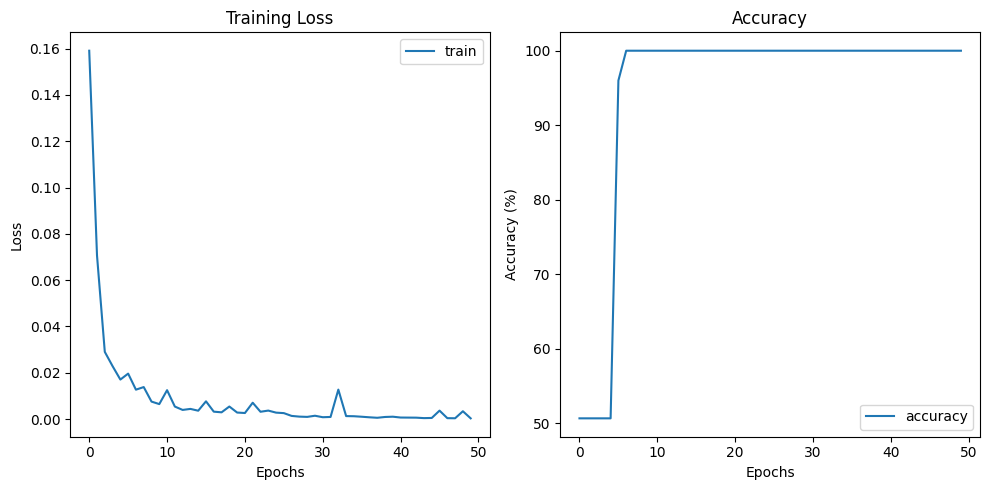

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(1, 8, kernel_size=8, stride=1, padding=3)  # Reduced filters from 16 to 8
        self.bn1 = nn.BatchNorm1d(8)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(8, 16, kernel_size=4, stride=1, padding=2)  # Reduced filters from 32 to 16
        self.bn2 = nn.BatchNorm1d(16)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Third convolutional block
        self.conv3 = nn.Conv1d(16, 32, kernel_size=2, stride=1, padding=1)  # Reduced filters from 64 to 32
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers with reduced complexity
        self.fc1 = nn.Linear(32 * 256, 64)  # Reduced from 128 to 64
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(64, 2)
        
        # L2 regularization can be added during optimizer creation:
        # optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    def forward(self, x):
        # Ensure input is the correct shape
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)
        
        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (sample, label) in enumerate(dataloader):
        sample, label = sample.to(device), label.to(device)

        pred = model(sample)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.cpu().detach().numpy()


def test(dataloader, model):
    model.eval()
    total, correct = 0, 0
    test_loss = 0

    with torch.no_grad():
        for sample, label in dataloader:
            sample, label = sample.to(device), label.to(device)
            output = model(sample)
            test_loss += loss_fn(output, label).item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    accuracy = 100 * correct / total
    test_loss /= len(dataloader)

    return accuracy, test_loss


epochs = 50
train_losses = []
test_losses = []
accuracies = []

for t in range(epochs):
    
    train_loss = train(training_dataloader, model, loss_fn, optimizer)
    accuracy, test_loss = test(testing_dataloader, model)
    print(f"Epoch {t+1}:\tAccuracy: {accuracy:.2f}%\tTest Loss: {test_loss:.6f}\tTrain Loss: {train_loss:.6f}")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print("Done!")
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
